In [40]:
import gym
import gym_minigrid

from oracle.oracle import Oracle, OracleWrapper
from oracle.lang import parser, TreeToGrid

import numpy as np
import pytest

from agents import PPOAgent
from utils import GAEtrain

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SharedCNN(nn.Module):
    def __init__(self, action_dim=7):
        super(SharedCNN, self).__init__()

        self.image_conv = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU())

        self.policy_head = nn.Linear(64, action_dim)
        self.value_head = nn.Linear(64, 1)
        self.activation = nn.ReLU()

    def forward(self, x, flag="policy"):
        # Shared Body
        x = x.view(-1, 3, 7, 7)  # x: (batch, C_in, H_in, W_in)
        x = self.image_conv(x).squeeze()  # x: (batch, hidden)
        # Split heads
        if flag == "policy":
            x_pol = self.policy_head(x)
            return x_pol
        elif flag == "value":
            x_val = self.value_head(x)
            return x_val

In [ ]:
class PPOAgent():
    def __init__(self, state_dim, action_dim, hidden_dim=64, learning_rate=0.001,
                 gamma=0.99, clip_param=0.2, value_param=1, entropy_param=0.01,
                 lmbda=0.95, backward_epochs=2):
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.lmbda = lmbda

        self.model = SharedCNN().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)

        self.clip_param = clip_param
        self.entropy_param = entropy_param
        self.value_param = value_param
        self.episode = 0
        self.T = 1

        self.done = True
        self.data = []
        self.backward_epochs = backward_epochs

    def act(self, observation, exploration=True):
        # Calculate policy
        observation = torch.FloatTensor(observation).to(device)
        logits = self.model(observation, flag="policy")
        action_prob = F.softmax(logits.squeeze()/self.T, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        probs = action_prob[action]  # Policy log grad
        entropy = dist.entropy()  # Entropy regularizer
        return action.detach().item(), probs, entropy

    def update(self):
        obs, a, reward, next_obs, done, log_prob, entropy = self.get_batch()

        for i in range(self.backward_epochs):
            # Get current V
            V_pred = self.model(obs, flag="value").squeeze()
            # Get next V
            next_V_pred = self.model(next_obs, flag="value").squeeze()

            # Compute TD error
            target = reward.squeeze().to(device) + self.gamma * next_V_pred * done.squeeze().to(device)
            td_error = (target - V_pred).detach()

            # Generalised Advantage Estimation
            advantage_list = []
            advantage = 0.0
            for delta in reversed(td_error):
                advantage = self.gamma * self.lmbda * advantage + delta
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.FloatTensor(advantage_list).to(device)

            # Clipped PPO Policy Loss
            logits = self.model(obs, flag="policy")
            probs = F.softmax(logits, dim=-1)
            pi_a = probs.squeeze(1).gather(1, torch.LongTensor(a.long()).to(device))
            ratio = torch.exp(torch.log(pi_a) - torch.log(log_prob))
            surrogate1 = ratio * advantage
            surrogate2 = advantage * torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param)
            L_clip = torch.min(surrogate1, surrogate2).mean()

            # Entropy regularizer
            L_entropy = self.entropy_param * entropy.detach().mean()

            # Value function loss
            L_value = self.value_param * F.smooth_l1_loss(V_pred, target.detach())

            total_loss = -(L_clip - L_value + L_entropy).to(device)

            # Update params
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
        return total_loss.item()

    def store(self, transition):
        self.data.append(transition)

    def get_batch(self):
        obs_batch = []
        a_batch = []
        r_batch = []
        next_obs_batch = []
        log_prob_batch = []
        entropy_batch = []
        done_batch = []
        for transition in self.data:
            obs, a, r, next_obs, log_prob, entropy, done = transition

            obs_batch.append(obs)
            a_batch.append([a])
            r_batch.append([r])
            next_obs_batch.append(next_obs)
            log_prob_batch.append([log_prob])
            entropy_batch.append([entropy])
            done_bool = 0 if done else 1
            done_batch.append([done_bool])

        obs = torch.FloatTensor(obs_batch).to(device)
        a = torch.FloatTensor(a_batch).to(device)
        r = torch.FloatTensor(r_batch).to(device)
        next_obs = torch.FloatTensor(next_obs_batch).to(device)
        log_prob = torch.FloatTensor(log_prob_batch).to(device)
        entropy = torch.FloatTensor(entropy_batch).to(device)
        done = torch.FloatTensor(done_batch).to(device)

        self.data = []

        return obs, a, r, next_obs, done, log_prob, entropy

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
# Helper
def show_state(env, step=0):
    plt.figure(3, figsize=(10, 10))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # pause for plots to update
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(0.0001) 

In [42]:
# Environment
env = gym.make("MiniGrid-Empty-8x8-v0")  # Use "Switch4-v0" for the Switch-4 game
env.seed(0)
state_dim = env.observation_space['image'].shape
action_dim = env.action_space.n


In [43]:
oracle = Oracle(parser, TreeToGrid)
env = OracleWrapper(env, oracle)

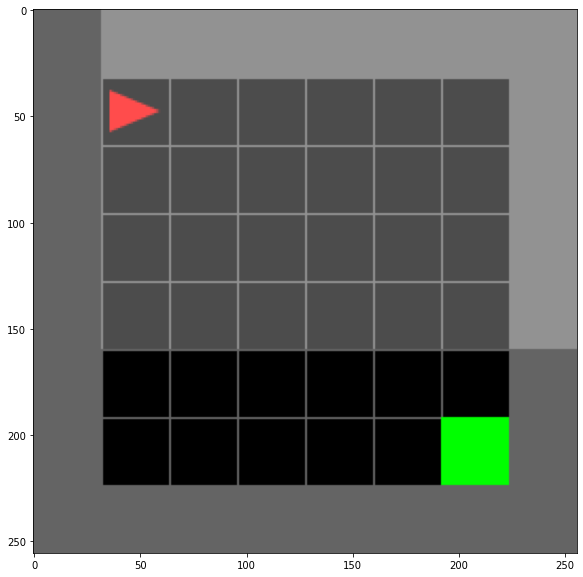

In [44]:
obvs = env.reset()
show_state(env)

In [79]:
tree = parser.parse("door is open")
state_premise = TreeToGrid().transform(tree)
state_premise

state_premise(object_id=4, color_id=None, state_id=0)

In [78]:
# We have:
env._answer("green door is closed")

# We want:
env.step_oracle("green door is closed")

# answer - (0,0) (0,1) (1, 1)
# reward -  -1

no such object


In [10]:
# Environment
#env = gym.make("MiniGrid-Empty-8x8-v0")  # Use "Switch4-v0" for the Switch-4 game
#env.seed(0)
#state_dim = env.observation_space['image'].shape
#action_dim = env.action_space.n

# Agent Params
hidden_dim = 32
lr = 0.001
gamma = 0.99
lmbda = 0.95
clip = 0.1
entropy_param = 0.1
value_param = 1

N_eps = 300
train_log_interval = 50

runs = 5

# Store data for each run
runs_reward = []

for i in range(runs):
    print(f"========================== TRAINING - RUN {i+1:.0f}/{runs:.0f} ==========================")
    # Agent
    agent = PPOAgent.PPOAgent(state_dim, action_dim, hidden_dim, 
                        lr, gamma, clip, value_param, entropy_param)
        
    _, train_reward = GAEtrain.GAEtrain(env, agent, exploration = True,
                               n_episodes = N_eps, log_interval = train_log_interval,
                                verbose = True)

    # store result for every run
    runs_reward.append(train_reward)

========================== TRAINING - RUN 1/5 ==========================
Episode: 50, Reward: 0.4
Episode: 100, Reward: 0.9
Episode: 150, Reward: 1.0
Episode: 200, Reward: 1.0


KeyboardInterrupt: 

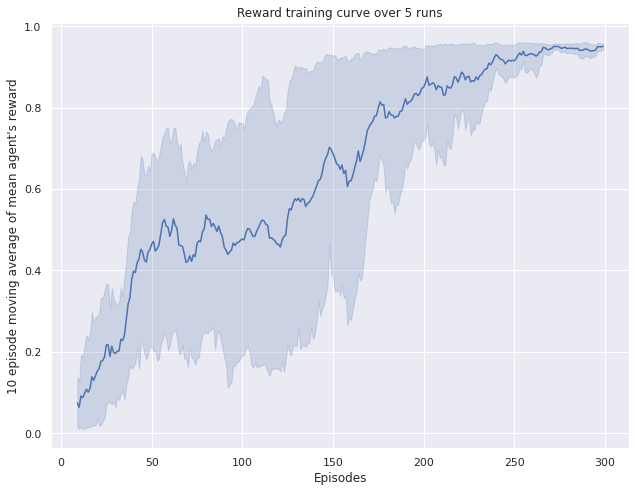

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)

window = 10
avg = pd.DataFrame(np.array(runs_reward)).T.rolling(window).mean().T

df_reward_v2 = pd.DataFrame(avg).melt()
sns.lineplot(ax=ax, x='variable', y='value', data=df_reward_v2)
ax.set_title(f"Reward training curve over {runs} runs")
ax.set_ylabel(f"{window} episode moving average of mean agent\'s reward")
ax.set_xlabel("Episodes")
plt.tight_layout()
plt.show()